# Modelo de Predicción del Precio del Gas

## Objetivo
El objetivo de este notebook es desarrollar un modelo de predicción del precio del gas que permita generar proyecciones
hasta el año 2026. Este modelo servirá como entrada para el posterior
modelo de predicción del precio de la electricidad.

Dado que no se dispone de información futura de variables exógenas,
se adopta un enfoque de serie temporal pura mediante el modelo Prophet.

## Carga de datos y librerías

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
# Si usas colab usar este scrip
df = pd.read_csv("/content/SET_INPUTS_BASE_0.csv", sep=';')
df.head()

,Year,Month,Day,DayOfYear,Demanda_GWh,Gen_Eolica_GWh,Gen_Solar_GWh,Pot_Eolica_GW,Pot_Solar_GW,Price_Elec_EUR_MWh,Temp_min_C_Nat,Temp_max_C_Nat,Temp_media_C_Nat,RadiacionGlobal_media_Wm2_Nat,Viento_media_ms_Nat,Price_Gas_EUR_MWh
0,2019,1,1,1,"547,404192","77,680013","25,58687","21,3969275","6,447067088","63,45458333","1,075316934","12,75559495","6,323518858","119,9719996","1,350332275","27,17"
1,2019,1,2,2,"701,784804","194,507772","25,453782","21,3969275","6,447067088","61,58541667","0,693947211","10,85852004","4,87310807","106,5043194","1,953407725","24,5"
2,2019,1,3,3,"746,345169","109,405705","22,307852","21,3969275","6,447067088","63,96166667","-0,831520694","10,12816949","3,880210679","106,2649415","1,495342364","24,76"
3,2019,1,4,4,"754,085459","79,098774","23,624898","21,3969275","6,447067088","66,83583333","-0,770384986","10,17460942","3,891902936","114,4084482","1,329866183","24,94"
4,2019,1,5,5,"681,461272","116,074127","25,952103","21,3969275","6,447067088","65,32875","-0,826576318","11,23432552","4,089401168","116,9314194","1,626659952","25,58"


In [ ]:
# Si usas VSC u otro usar este scrip
# df = pd.read_csv("Poner tu ruta del archivo aquí")
# df.head()

## Preparación de la serie temporal

Se construye la variable temporal `ds` y se elimina el 29 de febrero
para trabajar con años homogéneos de 365 días, con el fin de homogeneizar los datos del resto de data sets.

In [ ]:
df["ds"] = pd.to_datetime(df[["Year", "Month", "Day"]])

df = df[~((df["ds"].dt.month == 2) & (df["ds"].dt.day == 29))].copy()

df_prophet = df[["ds", "Price_Gas_EUR_MWh"]].rename(
    columns={"Price_Gas_EUR_MWh": "y"}
)

In [ ]:
# Poner las columnas como STR
cols = ['Demanda_GWh', 'Gen_Eolica_GWh', 'Gen_Solar_GWh', 'Price_Elec_EUR_MWh', 'Price_Gas_EUR_MWh']
df[cols] = df[cols].astype(str).apply(lambda x: x.str.replace(',', '.', regex=False))
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

## Entrenamiento del modelo Prophet

Se utiliza Prophet con estacionalidad anual,
sin variables exógenas, para permitir la proyección futura
hasta 2026 sin dependencias externas.

In [ ]:
# Convert 'y' column to numeric, handling comma as decimal separator
df_prophet['y'] = df_prophet['y'].astype(str).str.replace(',', '.', regex=False).astype(float)

# --- Split ---
train = df_prophet[df_prophet["ds"] < "2023-01-01"]
test  = df_prophet[df_prophet["ds"] >= "2023-01-01"]

# --- Entrenar modelo tuned ---
model = Prophet(
    yearly_seasonality=True,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=10,
    interval_width=0.8
)
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Validación del modelo

Se evalúa la capacidad de generalización del modelo sobre el año 2023
mediante métricas MAE, RMSE y WAPE.

In [ ]:
future_val = model.make_future_dataframe(
    periods=365,
    freq="D"
)

future_val = future_val[
    ~((future_val["ds"].dt.month == 2) & (future_val["ds"].dt.day == 29))
]

forecast_val = model.predict(future_val)

In [ ]:
real_2023 = df_prophet[
    (df_prophet["ds"] >= "2023-01-01") &
    (df_prophet["ds"] <= "2023-12-31")
]

pred_2023 = forecast_val[
    (forecast_val["ds"] >= "2023-01-01") &
    (forecast_val["ds"] <= "2023-12-31")
][["ds", "yhat"]]

eval_2023 = real_2023.merge(pred_2023, on="ds")

mae = mean_absolute_error(eval_2023["y"], eval_2023["yhat"])
rmse = np.sqrt(mean_squared_error(eval_2023["y"], eval_2023["yhat"]))
wape = np.sum(np.abs(eval_2023["y"] - eval_2023["yhat"])) / np.sum(np.abs(eval_2023["y"]))
mean_precio_gas = df['Price_Gas_EUR_MWh'].mean()

print(f"MAE  : {mae:.2f} €")
print(f"RMSE : {rmse:.2f} €")
print(f"WAPE : {wape:.2%}")
print(f"La media del precio del gas es: {mean_precio_gas:.2f} €")

MAE  : 15.16 €
RMSE : 17.82 €
WAPE : 38.66%
La media del precio del gas es: 42.51 €


## Proyección del Precio del Gas (2024–2026)

Una vez validado el modelo, se genera la predicción futura
del precio hasta el año 2026.

In [ ]:
future = model.make_future_dataframe(
    periods=3 * 365,
    freq="D"
)

future = future[
    ~((future["ds"].dt.month == 2) & (future["ds"].dt.day == 29))
]

forecast = model.predict(future)

In [ ]:
precio_futuro = forecast[
    (forecast["ds"] >= "2024-01-01") &
    (forecast["ds"] <= "2026-12-31")
][["ds", "yhat", "yhat_lower", "yhat_upper"]]

precio_futuro.head()

,ds,yhat,yhat_lower,yhat_upper
1825,2024-01-01,14.804929,-55.839502,83.267734
1826,2024-01-02,14.309719,-53.757313,81.194006
1827,2024-01-03,14.136258,-51.888816,80.915685
1828,2024-01-04,13.810747,-52.125139,81.343019
1829,2024-01-05,12.596856,-45.650690,73.019471


## Conclusiones

El modelo Prophet presenta un error relativo en torno al 38,66 % (WAPE),
mostrando una capacidad de generalización bastante inadecuada. Su uso como modelo
principal para la generación del precio futuro no garantiza la coherencia
temporal del análisis.

Evolución histórica del precio del gas

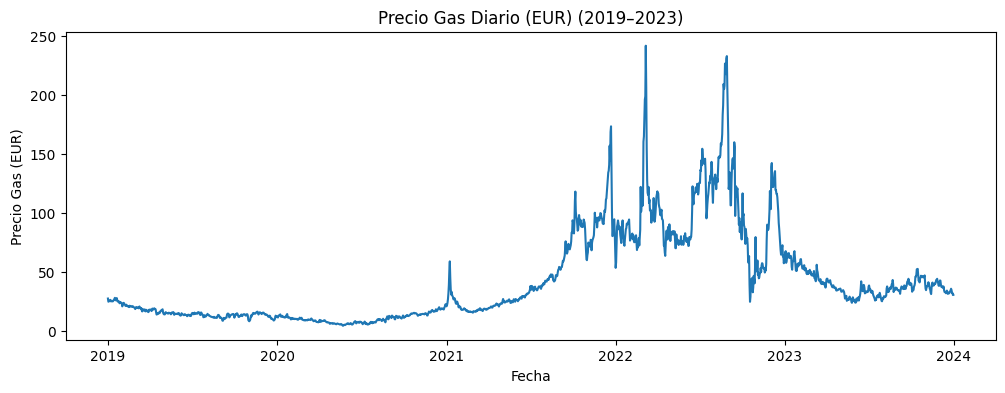

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df_prophet["ds"], df_prophet["y"])
plt.title("Precio Gas Diario (EUR) (2019–2023)")
plt.xlabel("Fecha")
plt.ylabel("Precio Gas (EUR)")
plt.show()

### Descomposición de la serie temporal

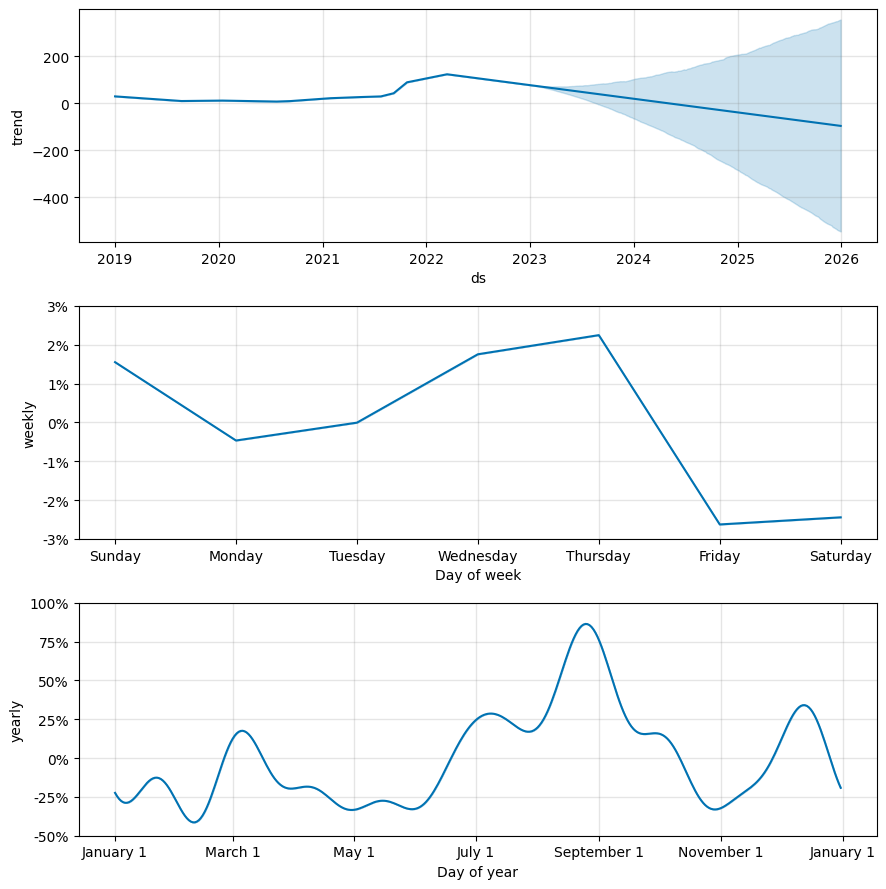

In [ ]:
model.plot_components(forecast)
plt.show()

### Validación del modelo (2023)

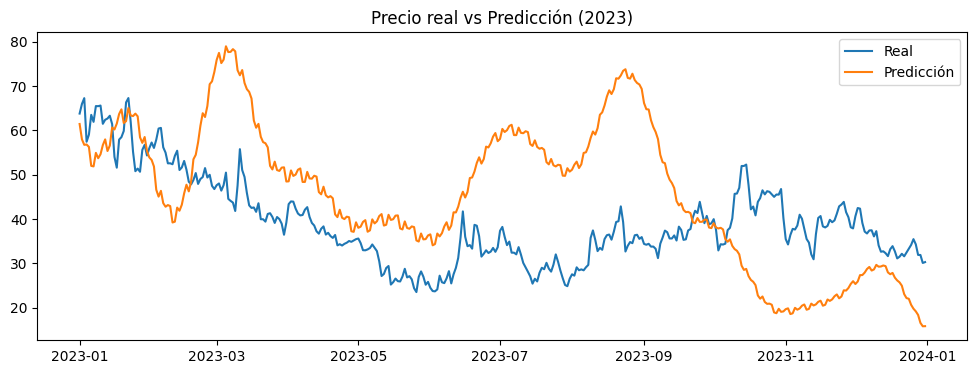

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(real_2023["ds"], real_2023["y"], label="Real")
plt.plot(pred_2023["ds"], pred_2023["yhat"], label="Predicción")
plt.legend()
plt.title("Precio real vs Predicción (2023)")
plt.show()

### Proyección del precio del gas (2024–2026)

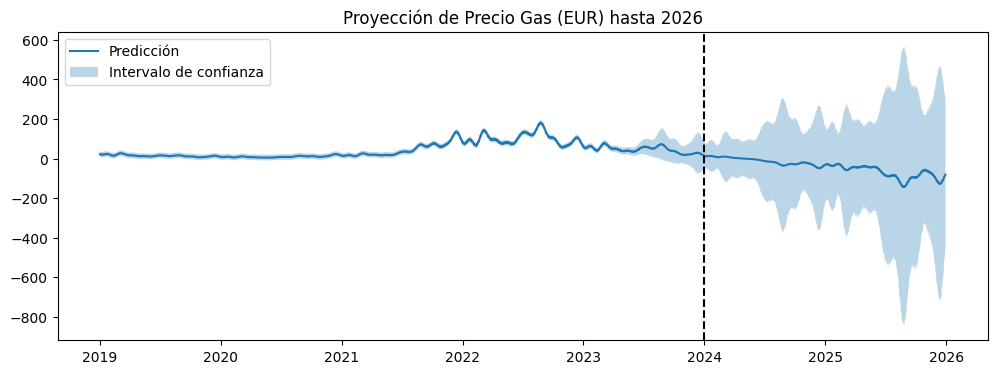

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(forecast["ds"], forecast["yhat"], label="Predicción")
plt.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    alpha=0.3,
    label="Intervalo de confianza"
)
plt.axvline(pd.to_datetime("2023-12-31"), linestyle="--", color="black")
plt.legend()
plt.title("Proyección de Precio Gas (EUR) hasta 2026")
plt.show()

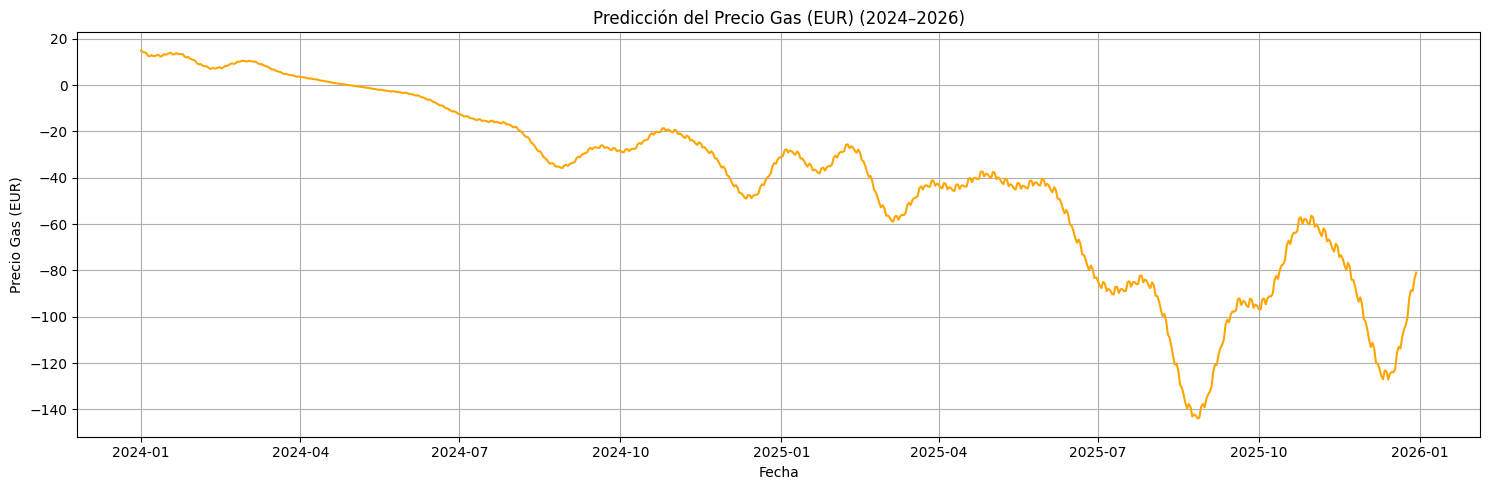

In [ ]:
# --- Subconjunto futuro 2024-2026 ---
pred_3y = forecast[
    (forecast["ds"] >= "2024-01-01") &
    (forecast["ds"] <= "2026-12-31")
].copy()

# --- Gráfico ---
plt.figure(figsize=(15, 5))
plt.plot(pred_3y["ds"], pred_3y["yhat"], label="Predicción 2024–2026", color="orange")
plt.title("Predicción del Precio Gas (EUR) (2024–2026)")
plt.xlabel("Fecha")
plt.ylabel("Precio Gas (EUR)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail(10)

,ds,yhat,yhat_lower,yhat_upper
2544,2025-12-21,-113.734675,-644.134255,417.366469
2545,2025-12-22,-108.536147,-612.199732,401.663043
2546,2025-12-23,-105.496111,-598.050016,392.768208
2547,2025-12-24,-103.563986,-586.030504,390.831085
2548,2025-12-25,-100.349894,-566.576156,368.711635
2549,2025-12-26,-91.983109,-520.867490,340.386973
2550,2025-12-27,-88.521290,-495.981707,329.548354
2551,2025-12-28,-88.854882,-506.946702,329.560104
2552,2025-12-29,-83.592487,-468.402110,307.798400
2553,2025-12-30,-80.961155,-455.742022,296.836660


In [ ]:
# Filtrar el DataFrame 'forecast_all' para el rango de fechas deseado
export_df = forecast[
    (forecast['ds'] >= '2024-01-01') &
    (forecast['ds'] <= '2026-12-31')
].copy() # Usar .copy() para evitar SettingWithCopyWarning

# Extraer Year, Month, Day de la columna 'ds'
export_df['Year'] = export_df['ds'].dt.year
export_df['Month'] = export_df['ds'].dt.month
export_df['Day'] = export_df['ds'].dt.day

# Seleccionar las columnas relevantes y reordenarlas
export_df = export_df[['Year', 'Month', 'Day', 'yhat', 'yhat_lower', 'yhat_upper']]

# Renombrar columnas para mayor claridad en el Excel
export_df.rename(columns={
    'yhat': 'Precio_Gas_Predicho',
    'yhat_lower': 'Limite_Inferior_EUR',
    'yhat_upper': 'Limite_Superior_EUR'
}, inplace=True)

# Definir el nombre del archivo de Excel
excel_filename = 'prediccion_precio_gas_2024_2026.xlsx'

# Exportar a Excel
export_df.to_excel(excel_filename, index=False)

¡Datos de predicción exportados exitosamente a 'prediccion_precio_gas_2024_2026.xlsx' con columnas de Año, Mes y Día!
